# Holt-Winters-Models

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.api import ExponentialSmoothing
from datetime import date

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


The warning error displayed while running ExponentialSmoothing() seems to be irrelevant and due to out of date functions. See https://github.com/unit8co/darts/issues/241. This is the reason for importing ConvergenceWarning.

## CITYWIDE

In [33]:
df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/cleaned_rat_sightings.csv')

We set the cut off the date the training data. We will train on data before the cut_off date and then test on data after the cut_off date through to 2025-12-31. We also make the 'created_date' column usable.

In [34]:
cut_off = "2025-09-01"

In [35]:
df['created_date'] = pd.to_datetime(df['created_date']) 
df.sample(3)

unique_key        created_date          closed_date  \
93352     53589475 2022-03-07 23:59:47  2022-03-08 12:09:45   
101984    52215942 2021-10-17 21:37:56  2021-10-17 21:37:56   
112603    50844717 2021-06-11 09:05:57  2021-06-11 09:20:34   

                  location_type      zip     incident_address  \
93352   3+_family_apt._building  11215.0         310 4 STREET   
101984                    other  11201.0      98 FRONT STREET   
112603  3+_family_apt._building  10025.0  900 WEST END AVENUE   

            street_name     cross_street_1   cross_street_2  \
93352          4 STREET           5 AVENUE         6 AVENUE   
101984     FRONT STREET  WASHINGTON STREET     ADAMS STREET   
112603  WEST END AVENUE           BROADWAY  WEST END AVENUE   

       intersection_street_1  ...         landmark  status  \
93352               5 AVENUE  ...         4 STREET  Closed   
101984     WASHINGTON STREET  ...     FRONT STREET  Closed   
112603              BROADWAY  ...  WEST END AVENUE  Closed   

       resolution_action_updated_date community_board    borough x_coordinate  \
93352             2022-03-07 23:59:47     06 BROOKLYN   BROOKLYN     988885.0   
101984            2021-10-17 21:37:56     02 BROOKLYN   BROOKLYN     987335.0   
112603            2021-06-11 09:05:57    07 MANHATTAN  MANHATTAN     992815.0   

       y_coordinate   latitude  longitude  days_to_close  
93352      184084.0  40.671944 -73.983291            0.0  
101984     195213.0  40.702491 -73.988874            0.0  
112603     230832.0  40.800252 -73.969064            0.0  

[3 rows x 23 columns]

In [36]:
daily_counts = df.groupby(df['created_date'].dt.date).size().reset_index(name='count')
df = daily_counts
df['created_date'] = pd.to_datetime(df['created_date']) 
display(df.sample(3))
print("\n The column 'count' returns the number of entries with the given created date.")

created_date  count
1161   2023-03-07     57
498    2021-05-13     90
23     2020-01-24     51


 The column 'count' returns the number of entries with the given created date.


In [ ]:
df_test = df[df['created_date']>=cut_off].copy()
df_train = df[df['created_date']<cut_off].copy()

holt_winters = ExponentialSmoothing(df_train['count'].values,
                                      seasonal='add',
                                      seasonal_periods=365).fit(optimized = True)

In [38]:
plt.figure(figsize=(200,60))

plt.plot(df_train['created_date'], df_train['count'], 'o', color='b', label="Training Data", alpha = 1, markersize =18)

plt.plot(df_train['created_date'], holt_winters.fittedvalues, 'g-', label="Holt-Winter Fit", linewidth = 8)

plt.plot(df_test['created_date'], df_test['count'], 'o', color='b', label="Test Data", alpha= 0.8, markersize =18)

plt.plot(df_test['created_date'], holt_winters.forecast(len(df_test['created_date'])), color='black', label="Holt-Winters Predictions", linewidth =8)


plt.xlabel("Date", fontsize=90)
plt.ylabel("Rat Sightings by Day", fontsize=90)
plt.xticks(fontsize=80)
plt.yticks(fontsize=80)


plt.title(f"Holt-Winters Prediction Trained on Data Before and Tested on Data After {cut_off}", fontsize=90)

# Evaluations for model

rmse = np.sqrt(np.mean((df_test['count'] - holt_winters.forecast(len(df_test['created_date'])))**2))
rss = np.sqrt(np.sum((df_test['count'] - holt_winters.forecast(len(df_test['created_date'])))**2))

# Add to the legend for easy reading

text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2])
labels.extend([f"RMSE: {rmse:.6f}", f"RSS: {rss:.6f}"])
plt.legend(handles=handles, labels=labels, fontsize=75)

plt.show()

## HOLT-WINTERS FORECASTING BY BOROUGH

In [39]:
df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv')
df['created_date'] = pd.to_datetime(df['created_date']) 
df.sample(3)

created_date        borough  count
390    2020-03-26          BRONX      5
5988   2023-06-19  STATEN ISLAND      1
6578   2023-10-19          BRONX      6

In [40]:
df = df[df['borough'] != 'Unspecified']

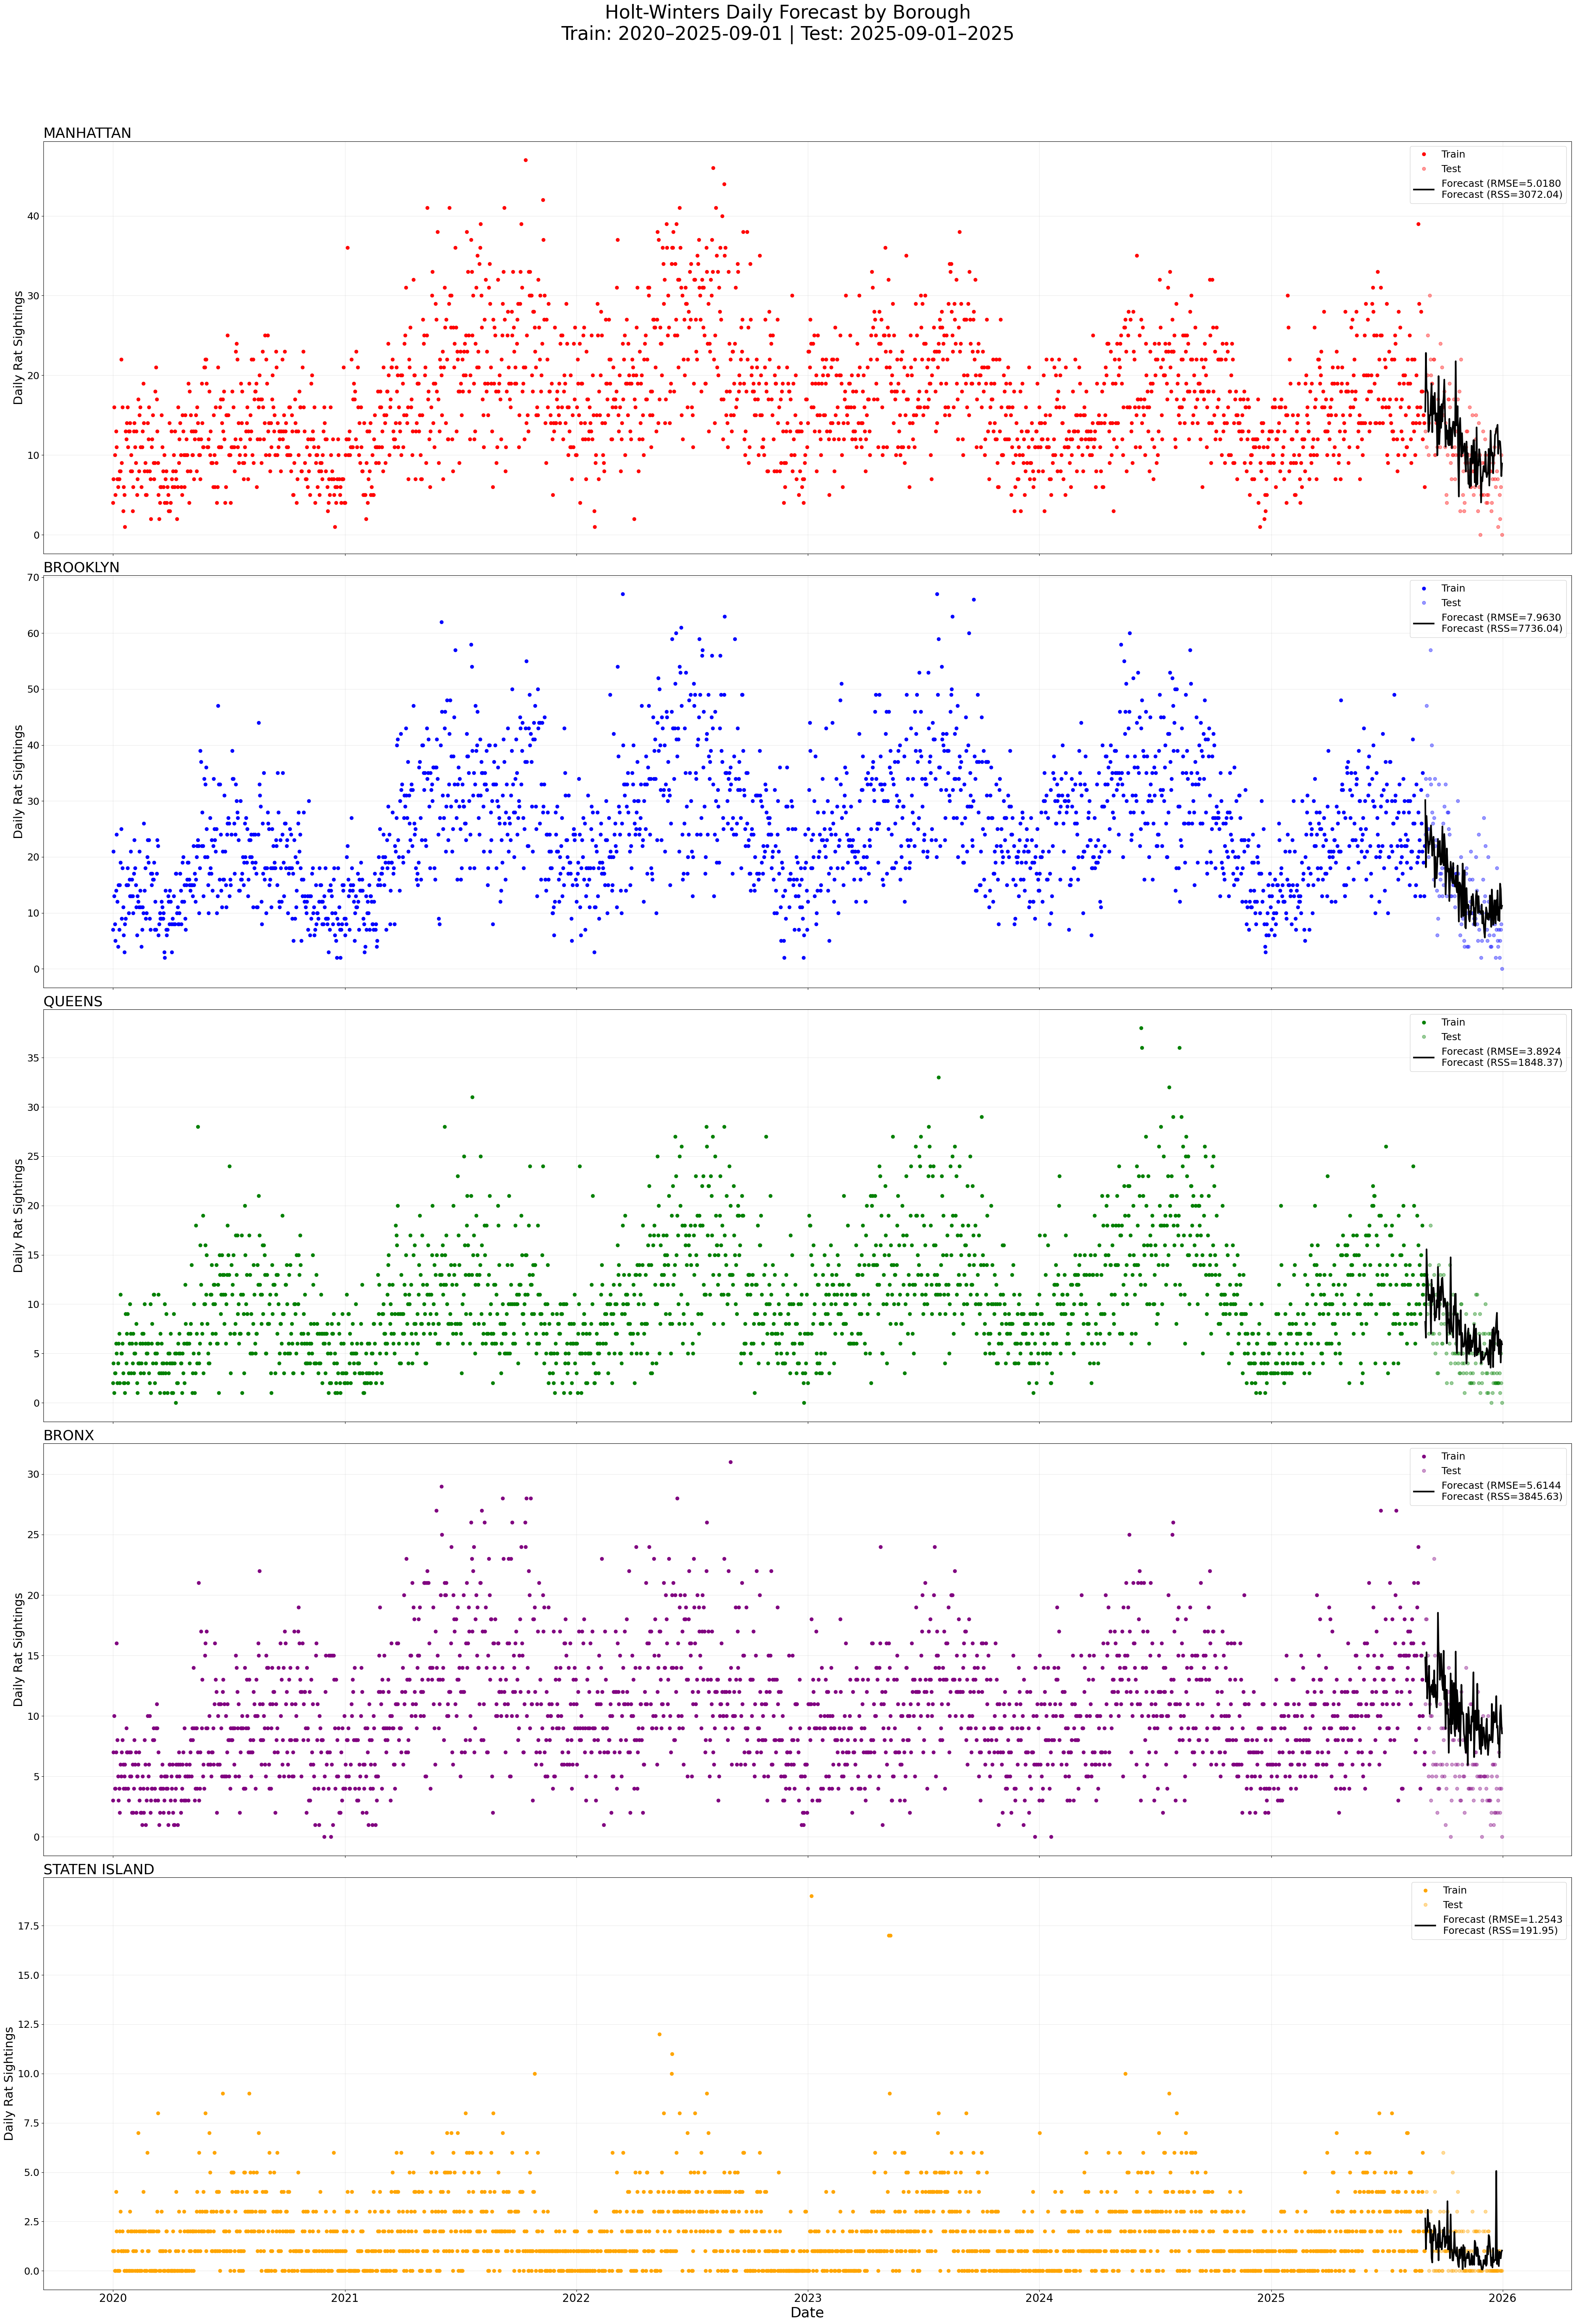

In [41]:
boroughs = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
colors = {'MANHATTAN': 'r', 'BROOKLYN': 'b','QUEENS': 'g','BRONX': 'purple','STATEN ISLAND': 'orange'}

cut_off = "2025-09-01"

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(40, 60),sharex=True)

for ax, borough in zip(axes, boroughs):
    dfb = df[df['borough'] == borough].copy()
    dfb['created_date'] = pd.to_datetime(dfb['created_date'])

    # Fill missing dates with 0 for count
    full_dates = pd.date_range('2020-01-01', '2025-12-31', freq='D')
    full_index = pd.MultiIndex.from_product([[borough], full_dates], names=['borough', 'created_date'])

    dfb = dfb.set_index(['borough', 'created_date']).reindex(full_index).fillna({'count': 0}).reset_index()
    dfb['count'] = dfb['count'].astype(int)

    # Split into training and testing data.
    df_train = dfb[dfb['created_date'] < cut_off]
    df_test  = dfb[dfb['created_date'] >= cut_off]

    # Holt-Winters
    model = ExponentialSmoothing(df_train['count'].values, trend='add', seasonal='add', seasonal_periods=360).fit(optimized=True)
    forecast = model.forecast(len(df_test))


    rmse = np.sqrt(np.mean((df_test['count'].values - forecast) ** 2))
    rss =  np.sum((df_test['count'].values - forecast)**2)

    c = colors[borough]

    # Plot 
    ax.plot(df_train['created_date'], df_train['count'], "o", color=c, label='Train')
    ax.plot(df_test['created_date'], df_test['count'], "o", color=c, alpha=0.4, label='Test')
    ax.plot(df_test['created_date'], forecast, linestyle='-', linewidth=3, color="black", label=f'Forecast (RMSE={rmse:.4f}\nForecast (RSS={rss:.2f})')
    
    # Title, Legend, Ticks
    ax.set_title(borough, fontsize=26, loc='left')
    ax.set_ylabel("Daily Rat Sightings", fontsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=18)

# Shared x-axis, title, and display.
axes[-1].set_xlabel("Date", fontsize=26)
axes[-1].tick_params(axis='x', labelsize=20)
fig.suptitle(f"Holt-Winters Daily Forecast by Borough\nTrain: 2020–{cut_off} | Test: {cut_off}–2025", fontsize=34)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../images/holt_winters_daily_borough.png", dpi=300, bbox_inches="tight")
plt.show()

If we compare the daily data for each of these, then the HOLT-WINTERS model performs better in all boroughs EXCEPT Bronx. I wonder why?